In [1]:
from helmet_assignment.score import NFLAssignmentScorer, check_submission
from helmet_assignment.features import add_track_features
import numpy as np
import pandas as pd
import itertools
import glob
import os
import cv2
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
from multiprocessing import Pool
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import random
from pathlib import Path
from sklearn.model_selection import KFold
from PIL import Image
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import re
import scipy

## Plot Utils

In [2]:
frame_pat = re.compile(r'(.*)_(\d+)')

def extract_video_frame(o): return frame_pat.findall(o)
def get_video_frame_path(o, dir='../data/usr/video_frames'): 
    name, frame_id = extract_video_frame(o)[0]
    fname = f"{name}_{str(frame_id).zfill(5)}.png"
    return f'{dir}/{name}/{fname}'

In [3]:
def plot_boxes(
    image_path, 
    boxes,
    linewidth=0.5,
    edgecolor="r",
    facecolor="none",
    ax = None, 
    grid = False,
    base = 100,
    figsize = (6,4)
):
    if ax is None: ax = plt.subplots(figsize=figsize)[1]
    ax.imshow(Image.open(image_path))
    ax.set_title(image_path.name)
    for box in boxes:
        x, y, w, h = box
        ax.add_patch(
            Rectangle((x, y), w, h, linewidth=linewidth, 
                      edgecolor=edgecolor, facecolor=facecolor))
    if grid: 
        ax.xaxis.set_major_locator(MultipleLocator(base))
        ax.yaxis.set_major_locator(MultipleLocator(base))
        ax.grid(which='major', color='#CCCCCC', linestyle='--', alpha=0.35)
        ax.grid(which='minor', color='#CCCCCC', linestyle=':', alpha=0.35)
    return ax

## Kfold split

In [4]:
BASE_DIR  = '../data'
LOCAL_RUN = True # use validation set instead of `test` set
FOLD      = [0] #'all' or [0,1]
N_CPU     = os.cpu_count()

In [5]:
TRAIN_VIDEO_PATHS = list(Path(f'{BASE_DIR}/train/').rglob('*.mp4'))
n_train_videos    = len(TRAIN_VIDEO_PATHS)
TRAIN_VIDEO_PATHS[:2], n_train_videos

([PosixPath('../data/train/58093_001923_Sideline.mp4'),
  PosixPath('../data/train/57790_002792_Endzone.mp4')],
 120)

In [6]:
# split training videos into 4 folds!
kfold_df = pd.DataFrame({'video_paths': TRAIN_VIDEO_PATHS, 'fold':-1})
kfold_df['video_name'] = kfold_df.video_paths.map(lambda o: o.name.strip('.mp4'))

kf = KFold(n_splits=4, shuffle=False)

for fold, (train_idx, val_idx) in enumerate(kf.split(kfold_df)):
    kfold_df.loc[val_idx, 'kfold']=fold

kfold_df.sample(4, random_state=1)

,video_paths,fold,video_name,kfold
95,../data/train/57597_000658_Endzone.mp4,-1,57597_000658_Endzone,3.0
54,../data/train/57775_000933_Sideline.mp4,-1,57775_000933_Sideline,1.0
59,../data/train/57682_002630_Sideline.mp4,-1,57682_002630_Sideline,1.0
117,../data/train/57785_002026_Sideline.mp4,-1,57785_002026_Sideline,3.0


## Baseline Helmet Mapping

In [7]:
if LOCAL_RUN and FOLD=='all': FOLD=[0,1,2,3]
FOLD

[0]

In [8]:
# get number of videos in test set
n_test_videos = len(os.listdir(f'{BASE_DIR}/test/')) 

# Run in debug mode unless during submission
debug = True if n_test_videos==6 else False
if LOCAL_RUN: debug=False

# Configurables
n_debug_samples = 1
random_state    = 42
CONF_THRE       = 0.3
max_iter        = 1000
DEG_STEP        = 3
DEG_MAX         = DEG_STEP*10

# Read in the data.
labels = pd.read_csv(f'{BASE_DIR}/train_labels.csv')
if LOCAL_RUN or debug:
    tracking = pd.read_csv(f'{BASE_DIR}/train_player_tracking.csv')
    helmets = pd.read_csv(f'{BASE_DIR}/train_baseline_helmets.csv')    
else:
    tracking = pd.read_csv(f'{BASE_DIR}/test_player_tracking.csv')
    helmets = pd.read_csv(f'{BASE_DIR}/test_baseline_helmets.csv')

**Just for information:**
1. `tracking`: Tracking contains tracking data of players, including `X` and `y` position. 
2. `labels`: Player label with bbox
3. `helmets`: Player helmets predictions on each `video_frame` by baseline helmet detector.

In [9]:
# predictions of helmet positions on each `video_frame`.
helmets.head(2)

,video_frame,left,width,top,height,conf
0,57778_004244_Endzone_1,598,18,278,18,0.080017
1,57778_004244_Endzone_1,856,16,294,22,0.089050


In [10]:
# Ground truth of `helmets` with player `labels`.
labels.head(2)

,video_frame,gameKey,playID,view,video,frame,label,left,width,top,height,impactType,isDefinitiveImpact,isSidelinePlayer
0,57583_000082_Endzone_1,57583,82,Endzone,57583_000082_Endzone.mp4,1,H90,245,21,327,29,None,False,False
1,57583_000082_Endzone_1,57583,82,Endzone,57583_000082_Endzone.mp4,1,V79,310,21,345,12,None,False,False


In [11]:
# player `X` and `y` tracking data on football field.
tracking.head(2)

,gameKey,playID,player,time,x,y,s,a,dis,o,dir,event
0,57583,82,H97,2018-09-14T00:23:45.500Z,38.89,28.06,0.0,0.0,0.0,261.28,222.79,NaN
1,57583,82,H97,2018-09-14T00:23:45.599Z,38.89,28.06,0.0,0.0,0.0,261.28,221.93,NaN


In [12]:
# Add estimated frame ID to player tracking data
tracking = add_track_features(tracking)
tracking.head(2)

,gameKey,playID,player,time,x,y,s,a,dis,o,dir,event,game_play,snap,isSnap,team,snap_offset,est_frame
0,57583,82,H97,2018-09-14 00:23:45.500000+00:00,38.89,28.06,0.0,0.0,0.0,261.28,222.79,NaN,57583_000082,2018-09-14 00:24:00.200000+00:00,False,Home,-14.700,-871
1,57583,82,H97,2018-09-14 00:23:45.599000+00:00,38.89,28.06,0.0,0.0,0.0,261.28,221.93,NaN,57583_000082,2018-09-14 00:24:00.200000+00:00,False,Home,-14.601,-865


In [13]:
def find_nearest(array, value):
    value = int(value)
    array = np.asarray(array).astype(int)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [14]:
def norm_arr(a):
    a = a-a.min()
    a = a/a.max()
    return a

In [15]:
def dist(a1, a2): return np.linalg.norm(a1-a2)

In [16]:
def dist_for_different_len(a1, a2):
    assert len(a1) >= len(a2), f'{len(a1)}, {len(a2)}'
    len_diff = len(a1) - len(a2)
    a2 = norm_arr(a2)
    if len_diff == 0:
        a1 = norm_arr(a1)
        return dist(a1,a2), ()
    else:
        min_dist = 10000
        min_detete_idx = None
        cnt = 0
        del_list = list(itertools.combinations(range(len(a1)),len_diff))
        if len(del_list) > max_iter:
            del_list = random.sample(del_list, max_iter)
        for detete_idx in del_list:
            this_a1 = np.delete(a1, detete_idx)
            this_a1 = norm_arr(this_a1)
            this_dist = dist(this_a1, a2)
            #print(len(a1), len(a2), this_dist)
            if  this_dist<min_dist:
                min_dist = this_dist
                min_detete_idx = detete_idx
                
        return min_dist, min_detete_idx    

In [17]:
def rotate_arr(u, t, deg=True):
    if deg == True:
        t = np.deg2rad(t)
    R = np.array([[np.cos(t), -np.sin(t)],
                  [np.sin(t),  np.cos(t)]])
    return  np.dot(R, u)

In [18]:
def match_player_ids(frame_tracking, x_center, min_dist = 10000):
    frame_tracking = frame_tracking.sort_values('x')
    min_idx = None
    min_x = None
    for deg in range(-DEG_MAX, DEG_MAX+1, DEG_STEP):
        rotated_tracking_arr = rotate_arr(np.array((frame_tracking['x'],frame_tracking['y'])), deg)
        this_dist, this_idx = dist_for_different_len(np.sort(rotated_tracking_arr[0]), x_center)
        if this_dist<min_dist:
            min_dist = this_dist
            min_idx = this_idx
            min_x = rotated_tracking_arr[0]
    frame_tracking['x_rot'] = min_x
    player_arr = frame_tracking.sort_values('x_rot')['player'].values
    players = np.delete(player_arr,min_idx)
    return min_dist, players

In [19]:
def updated_mapping_df(o):
    video_frame, bbox_df = o
    gameKey, playID, view, frame = video_frame.split('_')
    
    bbox_df = bbox_df.query('conf>@CONF_THRE').copy()
    bbox_df['x_center'] = (bbox_df.left + (bbox_df.width/2)).astype(int)
    bbox_df['neg_x_center'] = -bbox_df.x_center
        
    # find tracking data for this current game, playID & frame
    frame_tracking = tracking.query(f'game_play=="{gameKey}_{playID.zfill(6)}"').copy()
    est_frame = find_nearest(frame_tracking.est_frame.values, frame)
    frame_tracking = frame_tracking.query('est_frame==@est_frame').copy()
    
    # keep most confident scores
    if len(bbox_df)>len(frame_tracking):  
        bbox_df = bbox_df.sort_values('conf').tail(len(frame_tracking)).copy()
    
    bbox_df_pos = bbox_df.sort_values('x_center').copy()
    bbox_df_neg = bbox_df.sort_values('neg_x_center').copy()
    
    # swap `X` and `y` if view == 'Endzone'
    if view == 'Endzone':
        frame_tracking['x'], frame_tracking['y'] = frame_tracking['y'].copy(), frame_tracking['x'].copy()   
    
    min_dist_pos, player_ids_pos = match_player_ids(frame_tracking, bbox_df_pos['x_center'].values)
    min_dist_neg, player_ids_neg = match_player_ids(frame_tracking, bbox_df_neg['neg_x_center'].values)

    target_df, player_ids = (bbox_df_pos, player_ids_pos) if min_dist_pos<min_dist_neg else (bbox_df_neg, player_ids_neg)
    target_df['label'] = player_ids

    return target_df[['video_frame','left','width','top','height','label']]

In [20]:
kfold       = 0
val_df      = kfold_df.query(f"kfold=={kfold}").reset_index(drop=True).copy()
val_videos  = tuple(val_df.video_name.values)
val_helmets = helmets[helmets.video_frame.str.startswith(val_videos)].reset_index(drop=True).copy()
val_labels  = labels[labels.video_frame.str.startswith(val_videos)].reset_index(drop=True).copy()
submission_df_list = []
df_list = list(val_helmets.groupby('video_frame'))
updated_mapping_df(df_list[0])

,video_frame,left,width,top,height,label
157433,57583_000082_Endzone_1,1218,24,175,30,H27
157434,57583_000082_Endzone_1,1071,26,297,24,V15
157432,57583_000082_Endzone_1,960,22,233,29,V87
157431,57583_000082_Endzone_1,957,23,358,18,H59
157427,57583_000082_Endzone_1,882,22,180,27,V86
157419,57583_000082_Endzone_1,871,23,358,18,H96
157420,57583_000082_Endzone_1,866,26,320,30,H36
157423,57583_000082_Endzone_1,768,22,344,18,V74
157424,57583_000082_Endzone_1,724,22,227,29,H56
157416,57583_000082_Endzone_1,662,16,349,12,V73


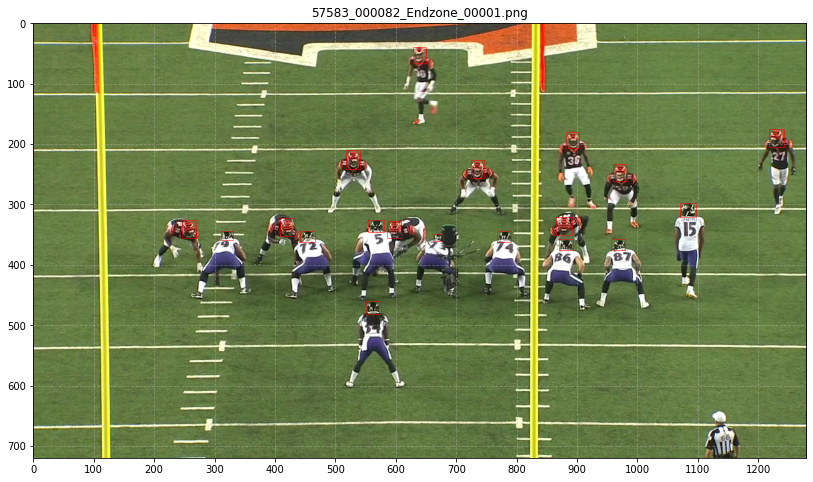

In [21]:
frame_image = get_video_frame_path(df_list[0][0])
boxes = df_list[0][1][['left', 'top', 'width', 'height']].values

plot_boxes(Path(frame_image), boxes, figsize=(15, 8), grid=True);

In [22]:
def add_cols(df):
    df['game_play'] = df['video_frame'].str.split('_').str[:2].str.join('_')
    if 'video' not in df.columns:
        df['video'] = df['video_frame'].str.split('_').str[:3].str.join('_') + '.mp4'
    return df

In [23]:
for kfold in [0,0,0,0,0]:
    val_df      = kfold_df.query(f"kfold=={kfold}").reset_index(drop=True).copy()
    val_videos  = tuple(val_df.video_name.values)
    print(f"validation videos in fold-{kfold}: {val_videos}, total: {len(val_videos)}")
    
    val_helmets = helmets[helmets.video_frame.str.startswith(val_videos)].reset_index(drop=True).copy()
    val_labels  = labels[labels.video_frame.str.startswith(val_videos)].reset_index(drop=True).copy()
    
    p = Pool(processes=N_CPU)
    submission_df_list = []
    df_list = list(val_helmets.groupby('video_frame'))
    with tqdm(total=len(df_list)) as pbar:
        for this_df in p.imap(updated_mapping_df, df_list):
            submission_df_list.append(this_df)
            pbar.update(1)
    p.close()
    
    submission_df = pd.concat(submission_df_list)
    
    val_helmets = add_cols(val_helmets)
    val_labels = add_cols(val_labels)
    # Select `n_debug_samples` worth of videos to debug with
    sample_videos = val_labels['video'].drop_duplicates().tolist()
    sample_gameplays = ['_'.join(x.split('_')[:2]) for x in sample_videos]
    val_tracking = tracking[tracking['game_play'].isin(sample_gameplays)]
    val_helmets = val_helmets[val_helmets['video'].isin(sample_videos)]
    val_labels = val_labels[val_labels['video'].isin(sample_videos)]

    scorer = NFLAssignmentScorer(val_labels)
    baseline_score = scorer.score(submission_df)
    print(f"validation score for fold-{kfold}: {baseline_score:0.4f}")

validation videos in fold-0: ('58093_001923_Sideline', '57790_002792_Endzone', '57782_000600_Endzone', '57790_002839_Sideline', '57583_000082_Endzone', '57911_002492_Endzone', '57992_000301_Endzone', '57700_001264_Endzone', '57597_001242_Endzone', '57906_000718_Endzone', '57782_000600_Sideline', '57786_003085_Endzone', '57684_001985_Endzone', '58107_004362_Sideline', '57778_004244_Endzone', '57915_003093_Sideline', '58104_000352_Endzone', '57787_003413_Sideline', '57684_001985_Sideline', '57787_003413_Endzone', '57784_001741_Sideline', '58102_002798_Sideline', '57596_002686_Sideline', '57997_003691_Sideline', '57992_000301_Sideline', '57686_002546_Sideline', '57596_002686_Endzone', '57676_003572_Endzone', '58098_001193_Endzone', '57913_000218_Endzone'), total: 30


  0%|          | 0/13038 [00:00<?, ?it/s]

validation score for fold-0: 0.3034
validation videos in fold-0: ('58093_001923_Sideline', '57790_002792_Endzone', '57782_000600_Endzone', '57790_002839_Sideline', '57583_000082_Endzone', '57911_002492_Endzone', '57992_000301_Endzone', '57700_001264_Endzone', '57597_001242_Endzone', '57906_000718_Endzone', '57782_000600_Sideline', '57786_003085_Endzone', '57684_001985_Endzone', '58107_004362_Sideline', '57778_004244_Endzone', '57915_003093_Sideline', '58104_000352_Endzone', '57787_003413_Sideline', '57684_001985_Sideline', '57787_003413_Endzone', '57784_001741_Sideline', '58102_002798_Sideline', '57596_002686_Sideline', '57997_003691_Sideline', '57992_000301_Sideline', '57686_002546_Sideline', '57596_002686_Endzone', '57676_003572_Endzone', '58098_001193_Endzone', '57913_000218_Endzone'), total: 30


  0%|          | 0/13038 [00:00<?, ?it/s]

validation score for fold-0: 0.2996
validation videos in fold-0: ('58093_001923_Sideline', '57790_002792_Endzone', '57782_000600_Endzone', '57790_002839_Sideline', '57583_000082_Endzone', '57911_002492_Endzone', '57992_000301_Endzone', '57700_001264_Endzone', '57597_001242_Endzone', '57906_000718_Endzone', '57782_000600_Sideline', '57786_003085_Endzone', '57684_001985_Endzone', '58107_004362_Sideline', '57778_004244_Endzone', '57915_003093_Sideline', '58104_000352_Endzone', '57787_003413_Sideline', '57684_001985_Sideline', '57787_003413_Endzone', '57784_001741_Sideline', '58102_002798_Sideline', '57596_002686_Sideline', '57997_003691_Sideline', '57992_000301_Sideline', '57686_002546_Sideline', '57596_002686_Endzone', '57676_003572_Endzone', '58098_001193_Endzone', '57913_000218_Endzone'), total: 30


  0%|          | 0/13038 [00:00<?, ?it/s]

validation score for fold-0: 0.3018
validation videos in fold-0: ('58093_001923_Sideline', '57790_002792_Endzone', '57782_000600_Endzone', '57790_002839_Sideline', '57583_000082_Endzone', '57911_002492_Endzone', '57992_000301_Endzone', '57700_001264_Endzone', '57597_001242_Endzone', '57906_000718_Endzone', '57782_000600_Sideline', '57786_003085_Endzone', '57684_001985_Endzone', '58107_004362_Sideline', '57778_004244_Endzone', '57915_003093_Sideline', '58104_000352_Endzone', '57787_003413_Sideline', '57684_001985_Sideline', '57787_003413_Endzone', '57784_001741_Sideline', '58102_002798_Sideline', '57596_002686_Sideline', '57997_003691_Sideline', '57992_000301_Sideline', '57686_002546_Sideline', '57596_002686_Endzone', '57676_003572_Endzone', '58098_001193_Endzone', '57913_000218_Endzone'), total: 30


  0%|          | 0/13038 [00:00<?, ?it/s]

validation score for fold-0: 0.3033
validation videos in fold-0: ('58093_001923_Sideline', '57790_002792_Endzone', '57782_000600_Endzone', '57790_002839_Sideline', '57583_000082_Endzone', '57911_002492_Endzone', '57992_000301_Endzone', '57700_001264_Endzone', '57597_001242_Endzone', '57906_000718_Endzone', '57782_000600_Sideline', '57786_003085_Endzone', '57684_001985_Endzone', '58107_004362_Sideline', '57778_004244_Endzone', '57915_003093_Sideline', '58104_000352_Endzone', '57787_003413_Sideline', '57684_001985_Sideline', '57787_003413_Endzone', '57784_001741_Sideline', '58102_002798_Sideline', '57596_002686_Sideline', '57997_003691_Sideline', '57992_000301_Sideline', '57686_002546_Sideline', '57596_002686_Endzone', '57676_003572_Endzone', '58098_001193_Endzone', '57913_000218_Endzone'), total: 30


  0%|          | 0/13038 [00:00<?, ?it/s]

validation score for fold-0: 0.2993


### Copied from NB with no updates

In [24]:
def mapping_df(args):
    video_frame, df = args
    gameKey,playID,view,frame = video_frame.split('_')
    gameKey = int(gameKey)
    playID = int(playID)
    frame = int(frame)
    this_tracking = tracking[(tracking['gameKey']==gameKey) & (tracking['playID']==playID)]
    est_frame = find_nearest(this_tracking.est_frame.values, frame)
    this_tracking = this_tracking[this_tracking['est_frame']==est_frame]
    len_this_tracking = len(this_tracking)
    df['center_h_p'] = (df['left']+df['width']/2).astype(int)
    df['center_h_m'] = (df['left']+df['width']/2).astype(int)*-1
    df = df[df['conf']>CONF_THRE].copy()
    if len(df) > len_this_tracking:
        df = df.tail(len_this_tracking)
    df_p = df.sort_values('center_h_p').copy()
    df_m = df.sort_values('center_h_m').copy()
    
    if view == 'Endzone':
        this_tracking['x'], this_tracking['y'] = this_tracking['y'].copy(), this_tracking['x'].copy()
    a2_p = df_p['center_h_p'].values
    a2_m = df_m['center_h_m'].values

    min_dist_p, min_detete_idx_p = dist_rot(this_tracking ,a2_p)
    min_dist_m, min_detete_idx_m = dist_rot(this_tracking ,a2_m)
    if min_dist_p < min_dist_m:
        min_dist = min_dist_p
        min_detete_idx = min_detete_idx_p
        tgt_df = df_p
    else:
        min_dist = min_dist_m
        min_detete_idx = min_detete_idx_m
        tgt_df = df_m
    #print(video_frame, len(this_tracking), len(df), len(df[df['conf']>CONF_THRE]), this_tracking['x'].mean(), min_dist_p, min_dist_m, min_dist)
    tgt_df['label'] = min_detete_idx
    return tgt_df[['video_frame','left','width','top','height','label']]

In [25]:
for kfold in [0,0,0,0,0]:
    val_df      = kfold_df.query(f"kfold=={kfold}").reset_index(drop=True).copy()
    val_videos  = tuple(val_df.video_name.values)
    print(f"validation videos in fold-{kfold}: {val_videos}, total: {len(val_videos)}")
    
    val_helmets = helmets[helmets.video_frame.str.startswith(val_videos)].reset_index(drop=True).copy()
    val_labels  = labels[labels.video_frame.str.startswith(val_videos)].reset_index(drop=True).copy()
    
    p = Pool(processes=N_CPU)
    submission_df_list = []
    df_list = list(val_helmets.groupby('video_frame'))
    with tqdm(total=len(df_list)) as pbar:
        for this_df in p.imap(updated_mapping_df, df_list):
            submission_df_list.append(this_df)
            pbar.update(1)
    p.close()
    
    submission_df = pd.concat(submission_df_list)
    
    val_helmets = add_cols(val_helmets)
    val_labels = add_cols(val_labels)
    # Select `n_debug_samples` worth of videos to debug with
    sample_videos = val_labels['video'].drop_duplicates().tolist()
    sample_gameplays = ['_'.join(x.split('_')[:2]) for x in sample_videos]
    val_tracking = tracking[tracking['game_play'].isin(sample_gameplays)]
    val_helmets = val_helmets[val_helmets['video'].isin(sample_videos)]
    val_labels = val_labels[val_labels['video'].isin(sample_videos)]

    scorer = NFLAssignmentScorer(val_labels)
    baseline_score = scorer.score(submission_df)
    print(f"validation score for fold-{kfold}: {baseline_score:0.4f}")

validation videos in fold-0: ('58093_001923_Sideline', '57790_002792_Endzone', '57782_000600_Endzone', '57790_002839_Sideline', '57583_000082_Endzone', '57911_002492_Endzone', '57992_000301_Endzone', '57700_001264_Endzone', '57597_001242_Endzone', '57906_000718_Endzone', '57782_000600_Sideline', '57786_003085_Endzone', '57684_001985_Endzone', '58107_004362_Sideline', '57778_004244_Endzone', '57915_003093_Sideline', '58104_000352_Endzone', '57787_003413_Sideline', '57684_001985_Sideline', '57787_003413_Endzone', '57784_001741_Sideline', '58102_002798_Sideline', '57596_002686_Sideline', '57997_003691_Sideline', '57992_000301_Sideline', '57686_002546_Sideline', '57596_002686_Endzone', '57676_003572_Endzone', '58098_001193_Endzone', '57913_000218_Endzone'), total: 30


  0%|          | 0/13038 [00:00<?, ?it/s]

validation score for fold-0: 0.3011
validation videos in fold-0: ('58093_001923_Sideline', '57790_002792_Endzone', '57782_000600_Endzone', '57790_002839_Sideline', '57583_000082_Endzone', '57911_002492_Endzone', '57992_000301_Endzone', '57700_001264_Endzone', '57597_001242_Endzone', '57906_000718_Endzone', '57782_000600_Sideline', '57786_003085_Endzone', '57684_001985_Endzone', '58107_004362_Sideline', '57778_004244_Endzone', '57915_003093_Sideline', '58104_000352_Endzone', '57787_003413_Sideline', '57684_001985_Sideline', '57787_003413_Endzone', '57784_001741_Sideline', '58102_002798_Sideline', '57596_002686_Sideline', '57997_003691_Sideline', '57992_000301_Sideline', '57686_002546_Sideline', '57596_002686_Endzone', '57676_003572_Endzone', '58098_001193_Endzone', '57913_000218_Endzone'), total: 30


  0%|          | 0/13038 [00:00<?, ?it/s]

validation score for fold-0: 0.3058
validation videos in fold-0: ('58093_001923_Sideline', '57790_002792_Endzone', '57782_000600_Endzone', '57790_002839_Sideline', '57583_000082_Endzone', '57911_002492_Endzone', '57992_000301_Endzone', '57700_001264_Endzone', '57597_001242_Endzone', '57906_000718_Endzone', '57782_000600_Sideline', '57786_003085_Endzone', '57684_001985_Endzone', '58107_004362_Sideline', '57778_004244_Endzone', '57915_003093_Sideline', '58104_000352_Endzone', '57787_003413_Sideline', '57684_001985_Sideline', '57787_003413_Endzone', '57784_001741_Sideline', '58102_002798_Sideline', '57596_002686_Sideline', '57997_003691_Sideline', '57992_000301_Sideline', '57686_002546_Sideline', '57596_002686_Endzone', '57676_003572_Endzone', '58098_001193_Endzone', '57913_000218_Endzone'), total: 30


  0%|          | 0/13038 [00:00<?, ?it/s]

validation score for fold-0: 0.2953
validation videos in fold-0: ('58093_001923_Sideline', '57790_002792_Endzone', '57782_000600_Endzone', '57790_002839_Sideline', '57583_000082_Endzone', '57911_002492_Endzone', '57992_000301_Endzone', '57700_001264_Endzone', '57597_001242_Endzone', '57906_000718_Endzone', '57782_000600_Sideline', '57786_003085_Endzone', '57684_001985_Endzone', '58107_004362_Sideline', '57778_004244_Endzone', '57915_003093_Sideline', '58104_000352_Endzone', '57787_003413_Sideline', '57684_001985_Sideline', '57787_003413_Endzone', '57784_001741_Sideline', '58102_002798_Sideline', '57596_002686_Sideline', '57997_003691_Sideline', '57992_000301_Sideline', '57686_002546_Sideline', '57596_002686_Endzone', '57676_003572_Endzone', '58098_001193_Endzone', '57913_000218_Endzone'), total: 30


  0%|          | 0/13038 [00:00<?, ?it/s]

validation score for fold-0: 0.2884
validation videos in fold-0: ('58093_001923_Sideline', '57790_002792_Endzone', '57782_000600_Endzone', '57790_002839_Sideline', '57583_000082_Endzone', '57911_002492_Endzone', '57992_000301_Endzone', '57700_001264_Endzone', '57597_001242_Endzone', '57906_000718_Endzone', '57782_000600_Sideline', '57786_003085_Endzone', '57684_001985_Endzone', '58107_004362_Sideline', '57778_004244_Endzone', '57915_003093_Sideline', '58104_000352_Endzone', '57787_003413_Sideline', '57684_001985_Sideline', '57787_003413_Endzone', '57784_001741_Sideline', '58102_002798_Sideline', '57596_002686_Sideline', '57997_003691_Sideline', '57992_000301_Sideline', '57686_002546_Sideline', '57596_002686_Endzone', '57676_003572_Endzone', '58098_001193_Endzone', '57913_000218_Endzone'), total: 30


  0%|          | 0/13038 [00:00<?, ?it/s]

validation score for fold-0: 0.2845


### Optimization for every angle and all player ID drop combinations

In [24]:
def dist_for_different_len(a1, a2):
    assert len(a1) >= len(a2), f'{len(a1)}, {len(a2)}'
    len_diff = len(a1) - len(a2)
    a2 = norm_arr(a2)
    if len_diff == 0:
        a1 = norm_arr(a1)
        return dist(a1,a2), ()
    else:
        min_dist = 10000
        min_detete_idx = None
        cnt = 0
        del_list = list(itertools.combinations(range(len(a1)),len_diff))
#         if len(del_list) > max_iter:
#             del_list = random.sample(del_list, max_iter)
        for detete_idx in del_list:
            this_a1 = np.delete(a1, detete_idx)
            this_a1 = norm_arr(this_a1)
            this_dist = dist(this_a1, a2)
            #print(len(a1), len(a2), this_dist)
            if min_dist > this_dist:
                min_dist = this_dist
                min_detete_idx = detete_idx
                
        return min_dist, min_detete_idx
    

In [25]:
def match_player_ids(frame_tracking, x_center, min_dist = 10000):
    frame_tracking = frame_tracking.sort_values('x')
    min_idx = None
    min_x = None
    for deg in range(-90, 90, 1):
        arr = rotate_arr(np.array((frame_tracking['x'],frame_tracking['y'])), deg)
        this_dist, this_idx = dist_for_different_len(np.sort(arr[0]), x_center)
        if this_dist<min_dist:
            min_dist = this_dist
            min_idx = this_idx
            min_x = arr[0]
    frame_tracking['x_rot'] = min_x
    player_arr = frame_tracking.sort_values('x_rot')['player'].values
    players = np.delete(player_arr,min_idx)
    return min_dist, players

In [ ]:
for kfold in FOLD:
    val_df      = kfold_df.query(f"kfold=={kfold}").reset_index(drop=True).copy()
    val_videos  = tuple(val_df.video_name.values)
    print(f"validation videos in fold-{kfold}: {val_videos}, total: {len(val_videos)}")
    
    val_helmets = helmets[helmets.video_frame.str.startswith(val_videos)].reset_index(drop=True).copy()
    val_labels  = labels[labels.video_frame.str.startswith(val_videos)].reset_index(drop=True).copy()
    
    p = Pool(processes=N_CPU)
    submission_df_list = []
    df_list = list(val_helmets.groupby('video_frame'))
    with tqdm(total=len(df_list)) as pbar:
        for this_df in p.imap(updated_mapping_df, df_list):
            submission_df_list.append(this_df)
            pbar.update(1)
    p.close()
    
    submission_df = pd.concat(submission_df_list)
    
    val_helmets = add_cols(val_helmets)
    val_labels = add_cols(val_labels)
    # Select `n_debug_samples` worth of videos to debug with
    sample_videos = val_labels['video'].drop_duplicates().tolist()
    sample_gameplays = ['_'.join(x.split('_')[:2]) for x in sample_videos]
    val_tracking = tracking[tracking['game_play'].isin(sample_gameplays)]
    val_helmets = val_helmets[val_helmets['video'].isin(sample_videos)]
    val_labels = val_labels[val_labels['video'].isin(sample_videos)]

    scorer = NFLAssignmentScorer(val_labels)
    baseline_score = scorer.score(submission_df)
    print(f"validation score for fold-{kfold}: {baseline_score:0.4f}")

validation videos in fold-0: ('58093_001923_Sideline', '57790_002792_Endzone', '57782_000600_Endzone', '57790_002839_Sideline', '57583_000082_Endzone', '57911_002492_Endzone', '57992_000301_Endzone', '57700_001264_Endzone', '57597_001242_Endzone', '57906_000718_Endzone', '57782_000600_Sideline', '57786_003085_Endzone', '57684_001985_Endzone', '58107_004362_Sideline', '57778_004244_Endzone', '57915_003093_Sideline', '58104_000352_Endzone', '57787_003413_Sideline', '57684_001985_Sideline', '57787_003413_Endzone', '57784_001741_Sideline', '58102_002798_Sideline', '57596_002686_Sideline', '57997_003691_Sideline', '57992_000301_Sideline', '57686_002546_Sideline', '57596_002686_Endzone', '57676_003572_Endzone', '58098_001193_Endzone', '57913_000218_Endzone'), total: 30


  0%|          | 0/13038 [00:00<?, ?it/s]

## Add `DeepSort`

In [ ]:
from deep_sort_pytorch.deep_sort.deep_sort import DeepSort
from deep_sort_pytorch.utils.parser import get_config

In [12]:
%%writefile deepsort.yaml

DEEPSORT:
    REID_CKPT: "../pretrained_weights/ckpt.t7"
    MAX_DIST: 0.2
    MIN_CONFIDENCE: 0.3
    NMS_MAX_OVERLAP: 0.5
    MAX_IOU_DISTANCE: 0.7
    MAX_AGE: 70
    N_INIT: 3
    NN_BUDGET: 100

Overwriting deepsort.yaml


In [13]:
def deepsort_helmets(video_data,
                     video_dir,
                     deepsort_config='deepsort.yaml',
                     plot=False,
                     plot_frames=[]):
    
    # Setup Deepsort
    cfg = get_config()
    cfg.merge_from_file(deepsort_config)    
    deepsort = DeepSort(cfg.DEEPSORT.REID_CKPT,
                        max_dist=cfg.DEEPSORT.MAX_DIST,
                        min_confidence=cfg.DEEPSORT.MIN_CONFIDENCE,
                        nms_max_overlap=cfg.DEEPSORT.NMS_MAX_OVERLAP,
                        max_iou_distance=cfg.DEEPSORT.MAX_IOU_DISTANCE,
                        max_age=cfg.DEEPSORT.MAX_AGE,
                        n_init=cfg.DEEPSORT.N_INIT,
                        nn_budget=cfg.DEEPSORT.NN_BUDGET,
                        use_cuda=True)
    
    # Run through frames.
    video_data = video_data.sort_values('frame').reset_index(drop=True)
    ds = []
    for frame, d in tqdm(video_data.groupby(['frame']), total=video_data['frame'].nunique()):
        d['x'] = (d['left'] + round(d['width'] / 2))
        d['y'] = (d['top'] + round(d['height'] / 2))

        xywhs = d[['x','y','width','height']].values

        cap = cv2.VideoCapture(f'{video_dir}/{myvideo}.mp4')
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame-1) # optional
        success, image = cap.read()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        confs = np.ones([len(d),])
        clss =  np.zeros([len(d),])
        outputs = deepsort.update(xywhs, confs, clss, image)

        if (plot and frame > cfg.DEEPSORT.N_INIT) or (frame in plot_frames):
            for j, (output, conf) in enumerate(zip(outputs, confs)): 

                bboxes = output[0:4]
                id = output[4]
                cls = output[5]

                c = int(cls)  # integer class
                label = f'{id}'
                color = compute_color_for_id(id)
                im = plot_one_box(bboxes, image, label=label, color=color, line_thickness=2)
            fig, ax = plt.subplots(figsize=(15, 10))
            video_frame = d['video_frame'].values[0]
            ax.set_title(f'Deepsort labels: {video_frame}')
            plt.imshow(im)
            plt.show()

        preds_df = pd.DataFrame(outputs, columns=['left','top','right','bottom','deepsort_cluster','class'])
        if len(preds_df) > 0:
            # TODO Fix this messy merge
            d = pd.merge_asof(d.sort_values(['left','top']),
                              preds_df[['left','top','deepsort_cluster']] \
                              .sort_values(['left','top']), on='left', suffixes=('','_deepsort'),
                              direction='nearest')
        ds.append(d)
    dout = pd.concat(ds)
    return dout

In [14]:
def add_deepsort_label_col(out):
    # Find the top occuring label for each deepsort_cluster
    sortlabel_map = out.groupby('deepsort_cluster')['label'].value_counts() \
        .sort_values(ascending=False).to_frame() \
        .rename(columns={'label':'label_count'}) \
        .reset_index() \
        .groupby(['deepsort_cluster']) \
        .first()['label'].to_dict()
    # Find the # of times that label appears for the deepsort_cluster.
    sortlabelcount_map = out.groupby('deepsort_cluster')['label'].value_counts() \
        .sort_values(ascending=False).to_frame() \
        .rename(columns={'label':'label_count'}) \
        .reset_index() \
        .groupby(['deepsort_cluster']) \
        .first()['label_count'].to_dict()
    
    out['label_deepsort'] = out['deepsort_cluster'].map(sortlabel_map)
    out['label_count_deepsort'] = out['deepsort_cluster'].map(sortlabelcount_map)

    return out

In [15]:
def score_vs_deepsort(myvideo, out, labels):
    # Score the base predictions compared to the deepsort postprocessed predictions.
    myvideo_mp4 = myvideo + '.mp4'
    labels_video = labels.query('video == @myvideo_mp4')
    scorer = NFLAssignmentScorer(labels_video)
    out_deduped = out.groupby(['video_frame','label']).first().reset_index()
    base_video_score = scorer.score(out_deduped)
    
    out_preds = out.drop('label', axis=1).rename(columns={'label_deepsort':'label'})
    print(out_preds.shape)
    out_preds = out_preds.groupby(['video_frame','label']).first().reset_index()
    print(out_preds.shape)
    deepsort_video_score = scorer.score(out_preds)
    print(f'{base_video_score:0.5f} before --> {deepsort_video_score:0.5f} deepsort')

In [16]:
# Add video and frame columns to submission.
submission_df['video'] = submission_df['video_frame'].str.split('_').str[:3].str.join('_')
submission_df['frame'] = submission_df['video_frame'].str.split('_').str[-1].astype('int')

In [17]:
submission_df.head(2)

,video_frame,left,width,top,height,label,video,frame
0,57584_002674_Endzone_1,1149,34,516,29,V24,57584_002674_Endzone,1
6,57584_002674_Endzone_1,1014,26,361,22,V97,57584_002674_Endzone,1


In [18]:
video_dir = '../data/train/'
# Loop through test videos and apply. If in debug mode show the score change.
outs = []
for myvideo, video_data in tqdm(submission_df.groupby('video'), total=submission_df['video'].nunique()):
    print(f'==== {myvideo} ====')
    out = deepsort_helmets(video_data, video_dir)        
    out = add_deepsort_label_col(out)
    outs.append(out)
    # Score
    score_vs_deepsort(myvideo, out, labels)

  0%|          | 0/30 [00:00<?, ?it/s]

==== 57584_002674_Endzone ====


  0%|          | 0/421 [00:00<?, ?it/s]

/opt/conda/envs/kaggle/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


(7194, 13)
(5941, 13)
0.18293 before --> 0.60059 deepsort
==== 57586_000540_Endzone ====


  0%|          | 0/492 [00:00<?, ?it/s]

(8342, 13)
(6337, 13)
0.27660 before --> 0.35284 deepsort
==== 57586_000540_Sideline ====


  0%|          | 0/492 [00:00<?, ?it/s]

(9211, 13)
(7130, 13)
0.21427 before --> 0.34923 deepsort
==== 57586_004152_Endzone ====


  0%|          | 0/515 [00:00<?, ?it/s]

(8683, 13)
(6527, 13)
0.18157 before --> 0.52579 deepsort
==== 57594_000923_Endzone ====


  0%|          | 0/509 [00:00<?, ?it/s]

(8038, 13)
(6751, 13)
0.31363 before --> 0.70314 deepsort
==== 57597_000658_Sideline ====


  0%|          | 0/549 [00:00<?, ?it/s]

(11266, 13)
(8981, 13)
0.32341 before --> 0.32989 deepsort
==== 57679_003316_Endzone ====


  0%|          | 0/336 [00:00<?, ?it/s]

(5590, 13)
(5000, 13)
0.24783 before --> 0.61245 deepsort
==== 57680_002206_Endzone ====


  0%|          | 0/485 [00:00<?, ?it/s]

(6666, 13)
(5161, 13)
0.09660 before --> 0.14521 deepsort
==== 57680_003470_Endzone ====


  0%|          | 0/349 [00:00<?, ?it/s]

(5564, 13)
(4435, 13)
0.19353 before --> 0.53044 deepsort
==== 57682_002630_Sideline ====


  0%|          | 0/446 [00:00<?, ?it/s]

(8173, 13)
(7396, 13)
0.23764 before --> 0.47570 deepsort
==== 57775_000933_Sideline ====


  0%|          | 0/365 [00:00<?, ?it/s]

(7795, 13)
(6536, 13)
0.35028 before --> 0.62917 deepsort
==== 57783_003374_Sideline ====


  0%|          | 0/451 [00:00<?, ?it/s]

(8916, 13)
(7284, 13)
0.29199 before --> 0.32983 deepsort
==== 57784_001741_Endzone ====


  0%|          | 0/292 [00:00<?, ?it/s]

(5373, 13)
(4714, 13)
0.32240 before --> 0.74364 deepsort
==== 57904_001367_Sideline ====


  0%|          | 0/501 [00:00<?, ?it/s]

(10939, 13)
(8771, 13)
0.30276 before --> 0.49976 deepsort
==== 57905_002404_Endzone ====


  0%|          | 0/351 [00:00<?, ?it/s]

(6149, 13)
(5153, 13)
0.39201 before --> 0.71139 deepsort
==== 57907_003615_Endzone ====


  0%|          | 0/351 [00:00<?, ?it/s]

(6419, 13)
(5241, 13)
0.16035 before --> 0.51628 deepsort
==== 57911_000147_Endzone ====


  0%|          | 0/362 [00:00<?, ?it/s]

(5838, 13)
(4653, 13)
0.13011 before --> 0.37947 deepsort
==== 57912_001325_Endzone ====


  0%|          | 0/360 [00:00<?, ?it/s]

(6411, 13)
(4773, 13)
0.09793 before --> 0.33448 deepsort
==== 57992_000350_Sideline ====


  0%|          | 0/458 [00:00<?, ?it/s]

(8090, 13)
(6361, 13)
0.08828 before --> 0.22945 deepsort
==== 57993_000475_Sideline ====


  0%|          | 0/397 [00:00<?, ?it/s]

(8039, 13)
(6430, 13)
0.35670 before --> 0.40406 deepsort
==== 58005_001612_Endzone ====


  0%|          | 0/451 [00:00<?, ?it/s]

(8316, 13)
(6937, 13)
0.33394 before --> 0.53676 deepsort
==== 58093_001923_Endzone ====


  0%|          | 0/486 [00:00<?, ?it/s]

(9260, 13)
(7614, 13)
0.24172 before --> 0.58288 deepsort
==== 58094_000423_Sideline ====


  0%|          | 0/372 [00:00<?, ?it/s]

(7959, 13)
(5282, 13)
0.04914 before --> 0.06557 deepsort
==== 58094_002819_Sideline ====


  0%|          | 0/387 [00:00<?, ?it/s]

(8514, 13)
(5828, 13)
0.07950 before --> 0.06728 deepsort
==== 58095_004022_Endzone ====


  0%|          | 0/481 [00:00<?, ?it/s]

(8253, 13)
(7380, 13)
0.28829 before --> 0.71226 deepsort
==== 58095_004022_Sideline ====


  0%|          | 0/482 [00:00<?, ?it/s]

(9201, 13)
(7332, 13)
0.24219 before --> 0.42690 deepsort
==== 58102_002798_Endzone ====


  0%|          | 0/366 [00:00<?, ?it/s]

(5639, 13)
(4650, 13)
0.13179 before --> 0.63317 deepsort
==== 58103_003494_Endzone ====


  0%|          | 0/366 [00:00<?, ?it/s]

(6381, 13)
(5171, 13)
0.39934 before --> 0.62222 deepsort
==== 58104_000352_Sideline ====


  0%|          | 0/350 [00:00<?, ?it/s]

(7289, 13)
(6038, 13)
0.31355 before --> 0.55128 deepsort
==== 58106_002918_Sideline ====


  0%|          | 0/548 [00:00<?, ?it/s]

(11054, 13)
(9786, 13)
0.26772 before --> 0.55655 deepsort


In [19]:
submission_deepsort = pd.concat(outs).copy()

In [20]:
ss = pd.read_csv('../data/sample_submission.csv')
# Final Checks
submission_deepsort['label_deepsort'] = submission_deepsort['label_deepsort'] \
    .fillna(submission_deepsort['label'])
submission_deepsort = submission_deepsort.drop('label', axis=1) \
    .rename(columns={'label_deepsort':'label'})[ss.columns]
# Drop duplicate labels
submission_deepsort = submission_deepsort.loc[
    ~submission_deepsort[['video_frame','label']].duplicated()]
assert check_submission(submission_deepsort)

submission_deepsort.head()

,video_frame,label,left,width,top,height
0,57584_002674_Endzone_1,V24,1149,34,516,29
1,57584_002674_Endzone_1,V90,191,27,345,27
2,57584_002674_Endzone_1,V55,346,27,398,23
3,57584_002674_Endzone_1,H73,418,24,303,31
4,57584_002674_Endzone_1,V95,470,23,357,19


In [21]:
deepsort_score = scorer.score(submission_deepsort)
print(f"validation score for fold-{kfold}: {deepsort_score:0.4f}")

validation score for fold-1: 0.4684


## Try a different Config

In [22]:
%%writefile deepsort.yaml

DEEPSORT:
    REID_CKPT: "../pretrained_weights/ckpt.t7"
    MAX_DIST: 0.2
    MIN_CONFIDENCE: 0.3
    NMS_MAX_OVERLAP: 0.5
    MAX_IOU_DISTANCE: 0.7
    MAX_AGE: 70
    N_INIT: 3
    NN_BUDGET: 22

Overwriting deepsort.yaml


In [23]:
video_dir = '../data/train/'
# Loop through test videos and apply. If in debug mode show the score change.
outs = []

for myvideo, video_data in tqdm(submission_df.groupby('video'), total=submission_df['video'].nunique()):
    print(f'==== {myvideo} ====')
    out = deepsort_helmets(video_data, video_dir)        
    out = add_deepsort_label_col(out)
    outs.append(out)
    # Score
    score_vs_deepsort(myvideo, out, labels)

  0%|          | 0/30 [00:00<?, ?it/s]

==== 57584_002674_Endzone ====


  0%|          | 0/421 [00:00<?, ?it/s]

(7194, 13)
(5782, 13)
0.18293 before --> 0.58257 deepsort
==== 57586_000540_Endzone ====


  0%|          | 0/492 [00:00<?, ?it/s]

(8342, 13)
(6232, 13)
0.27660 before --> 0.30799 deepsort
==== 57586_000540_Sideline ====


  0%|          | 0/492 [00:00<?, ?it/s]

(9211, 13)
(7321, 13)
0.21427 before --> 0.40285 deepsort
==== 57586_004152_Endzone ====


  0%|          | 0/515 [00:00<?, ?it/s]

(8683, 13)
(6388, 13)
0.18157 before --> 0.53587 deepsort
==== 57594_000923_Endzone ====


  0%|          | 0/509 [00:00<?, ?it/s]

(8038, 13)
(6841, 13)
0.31363 before --> 0.69881 deepsort
==== 57597_000658_Sideline ====


  0%|          | 0/549 [00:00<?, ?it/s]

(11266, 13)
(8901, 13)
0.32341 before --> 0.43108 deepsort
==== 57679_003316_Endzone ====


  0%|          | 0/336 [00:00<?, ?it/s]

(5590, 13)
(5017, 13)
0.24783 before --> 0.61151 deepsort
==== 57680_002206_Endzone ====


  0%|          | 0/485 [00:00<?, ?it/s]

(6666, 13)
(5117, 13)
0.09660 before --> 0.14016 deepsort
==== 57680_003470_Endzone ====


  0%|          | 0/349 [00:00<?, ?it/s]

(5564, 13)
(4702, 13)
0.19353 before --> 0.55635 deepsort
==== 57682_002630_Sideline ====


  0%|          | 0/446 [00:00<?, ?it/s]

(8173, 13)
(7355, 13)
0.23764 before --> 0.46556 deepsort
==== 57775_000933_Sideline ====


  0%|          | 0/365 [00:00<?, ?it/s]

(7795, 13)
(6536, 13)
0.35028 before --> 0.62917 deepsort
==== 57783_003374_Sideline ====


  0%|          | 0/451 [00:00<?, ?it/s]

(8916, 13)
(7366, 13)
0.29199 before --> 0.33340 deepsort
==== 57784_001741_Endzone ====


  0%|          | 0/292 [00:00<?, ?it/s]

(5373, 13)
(4667, 13)
0.32240 before --> 0.66875 deepsort
==== 57904_001367_Sideline ====


  0%|          | 0/501 [00:00<?, ?it/s]

(10939, 13)
(9012, 13)
0.30276 before --> 0.51553 deepsort
==== 57905_002404_Endzone ====


  0%|          | 0/351 [00:00<?, ?it/s]

(6149, 13)
(5081, 13)
0.39201 before --> 0.62254 deepsort
==== 57907_003615_Endzone ====


  0%|          | 0/351 [00:00<?, ?it/s]

(6419, 13)
(5233, 13)
0.16035 before --> 0.51723 deepsort
==== 57911_000147_Endzone ====


  0%|          | 0/362 [00:00<?, ?it/s]

(5838, 13)
(4690, 13)
0.13011 before --> 0.33930 deepsort
==== 57912_001325_Endzone ====


  0%|          | 0/360 [00:00<?, ?it/s]

(6411, 13)
(4701, 13)
0.09793 before --> 0.33230 deepsort
==== 57992_000350_Sideline ====


  0%|          | 0/458 [00:00<?, ?it/s]

(8090, 13)
(6233, 13)
0.08828 before --> 0.20047 deepsort
==== 57993_000475_Sideline ====


  0%|          | 0/397 [00:00<?, ?it/s]

(8039, 13)
(6345, 13)
0.35670 before --> 0.43648 deepsort
==== 58005_001612_Endzone ====


  0%|          | 0/451 [00:00<?, ?it/s]

(8316, 13)
(7010, 13)
0.33394 before --> 0.53659 deepsort
==== 58093_001923_Endzone ====


  0%|          | 0/486 [00:00<?, ?it/s]

(9260, 13)
(7851, 13)
0.24172 before --> 0.59470 deepsort
==== 58094_000423_Sideline ====


  0%|          | 0/372 [00:00<?, ?it/s]

(7959, 13)
(5499, 13)
0.04914 before --> 0.07593 deepsort
==== 58094_002819_Sideline ====


  0%|          | 0/387 [00:00<?, ?it/s]

(8514, 13)
(6004, 13)
0.07950 before --> 0.06651 deepsort
==== 58095_004022_Endzone ====


  0%|          | 0/481 [00:00<?, ?it/s]

(8253, 13)
(7187, 13)
0.28829 before --> 0.70775 deepsort
==== 58095_004022_Sideline ====


  0%|          | 0/482 [00:00<?, ?it/s]

(9201, 13)
(7343, 13)
0.24219 before --> 0.42316 deepsort
==== 58102_002798_Endzone ====


  0%|          | 0/366 [00:00<?, ?it/s]

(5639, 13)
(4644, 13)
0.13179 before --> 0.62584 deepsort
==== 58103_003494_Endzone ====


  0%|          | 0/366 [00:00<?, ?it/s]

(6381, 13)
(5241, 13)
0.39934 before --> 0.66054 deepsort
==== 58104_000352_Sideline ====


  0%|          | 0/350 [00:00<?, ?it/s]

(7289, 13)
(6079, 13)
0.31355 before --> 0.50962 deepsort
==== 58106_002918_Sideline ====


  0%|          | 0/548 [00:00<?, ?it/s]

(11054, 13)
(9845, 13)
0.26772 before --> 0.58589 deepsort


In [24]:
submission_deepsort = pd.concat(outs).copy()

In [25]:
ss = pd.read_csv('../data/sample_submission.csv')
# Final Checks
submission_deepsort['label_deepsort'] = submission_deepsort['label_deepsort'] \
    .fillna(submission_deepsort['label'])
submission_deepsort = submission_deepsort.drop('label', axis=1) \
    .rename(columns={'label_deepsort':'label'})[ss.columns]
# Drop duplicate labels
submission_deepsort = submission_deepsort.loc[
    ~submission_deepsort[['video_frame','label']].duplicated()]
assert check_submission(submission_deepsort)

submission_deepsort.head()

,video_frame,label,left,width,top,height
0,57584_002674_Endzone_1,V24,1149,34,516,29
1,57584_002674_Endzone_1,V90,191,27,345,27
2,57584_002674_Endzone_1,V55,346,27,398,23
3,57584_002674_Endzone_1,H73,418,24,303,31
4,57584_002674_Endzone_1,V95,470,23,357,19


In [26]:
deepsort_score = scorer.score(submission_deepsort)
print(f"validation score for fold-{kfold}: {deepsort_score:0.4f}")

validation score for fold-1: 0.4695
